In [ ]:
#| default_exp models.itransformer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from typing import Optional
from math import sqrt

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.common._modules import TransEncoder, TransEncoderLayer, AttentionLayer

# 1. Auxiliary functions

## 1.1 Attention

In [ ]:
#| exporti

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)      

## 1.2 Inverted embedding

In [ ]:
#| exporti

class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, hidden_size, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, hidden_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            # the potential to take covariates (e.g. timestamps) as tokens
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1)) 
        # x: [Batch Variate hidden_size]
        return self.dropout(x)

# 2. Model

In [ ]:
#| export

class iTransformer(BaseWindows):

    """ iTransformer

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `enc_in`: int, encoder input size
    `dec_in`: int, decoder input size
    `c_out`: int, output size
    `hidden_size`: int, dimension of the model
    `n_heads`: int, number of heads
    `e_layers`: int, number of encoder layers
    `d_layers`: int, number of decoder layers
    `d_ff`: int, dimension of fully-connected layer
    `factor`: int, attention factor
    `dropout`: float, dropout rate
    `use_norm`: bool, whether to normalize or not
    """

    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h,
                 input_size,
                 # Model specific
                 enc_in: int = 7,
                 dec_in: int = 7,
                 c_out: int = 7,
                 hidden_size: int = 512,
                 n_heads: int = 8,
                 e_layers: int = 2,
                 d_layers: int = 1,
                 d_ff: int = 2048,
                 factor: int = 1,
                 dropout: float = 0.1,
                 use_norm: bool = True,
                 # Inherited params
                 stat_exog_list = None,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 loss = MAE(),
                 valid_loss = None,
                 learning_rate: float = 1e-4,
                 max_steps: int = 1000,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = 1024,
                 start_padding_enabled: bool = False,
                 step_size: int = 1,
                 num_lr_decays: int = 0,
                 early_stop_patience_steps: int = -1,
                 scaler_type: str = 'identity',
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 random_seed: int = 1,
                 **trainer_kwargs):
        
        super(iTransformer, self).__init__(h=h,
                                           input_size=input_size,
                                           stat_exog_list = None,
                                           futr_exog_list = None,
                                           hist_exog_list = None,
                                           loss = loss,
                                           valid_loss = valid_loss,
                                           learning_rate = learning_rate,
                                           max_steps = max_steps,
                                           val_check_steps = val_check_steps,
                                           batch_size = batch_size,
                                           valid_batch_size = valid_batch_size,
                                           windows_batch_size = windows_batch_size,
                                           inference_windows_batch_size = inference_windows_batch_size,
                                           start_padding_enabled = start_padding_enabled,
                                           step_size = step_size,
                                           num_lr_decays = num_lr_decays,
                                           early_stop_patience_steps = early_stop_patience_steps,
                                           scaler_type = scaler_type,
                                           num_workers_loader = num_workers_loader,
                                           drop_last_loader = drop_last_loader,
                                           random_seed = random_seed,
                                           **trainer_kwargs)
        
        # Asserts
        if stat_exog_list is not None:
            raise Exception("iTransformer does not support static exogenous variables")
        if futr_exog_list is not None:
            raise Exception("iTransformer does not support future exogenous variables")
        if hist_exog_list is not None:
            raise Exception("iTransformer does not support historical exogenous variables")
        
        self.enc_in = enc_in
        self.dec_in = dec_in
        self.c_out = c_out
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.e_layers = e_layers
        self.d_layers = d_layers
        self.d_ff = d_ff
        self.factor = factor
        self.dropout = dropout
        self.use_norm = use_norm

        # Architecture
        self.enc_embedding = DataEmbedding_inverted(input_size, self.hidden_size, self.dropout)

        self.encoder = TransEncoder(
            [
                TransEncoderLayer(
                    AttentionLayer(
                        FullAttention(False, self.factor, attention_dropout=self.dropout), self.hidden_size, self.n_heads),
                    self.hidden_size,
                    self.d_ff,
                    dropout=self.dropout,
                    activation=F.gelu
                ) for l in range(self.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(self.hidden_size)
        )

        self.projector = nn.Linear(self.hidden_size, h, bias=True)
    
    def forecast(self, x_enc):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape # B L N
        # B: batch_size;    E: hidden_size; 
        # L: input_size;       S: horizon(h);
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc, None) # covariates (e.g timestamp) can be also embedded as tokens
        
        # B N E -> B N E                (B L E -> B L E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        # B N E -> B N S -> B S N 
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N] # filter the covariates

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))

        return dec_out
    
    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y']

        x = insample_y.unsqueeze(-1)
        y_pred = self.forecast(x)
        y_pred = y_pred[:, -self.h:, :]
        y_pred = self.loss.domain_map(y_pred)

        return y_pred    # [B, L, D]

# 3. Usage example

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from neuralforecast.utils import AirPassengersPanel
from neuralforecast.losses.pytorch import MAE, MSE

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = iTransformer(h=12,
                     input_size=24,
                     enc_in=6,
                     dec_in=6,
                     c_out=2,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MAE(),
                     batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

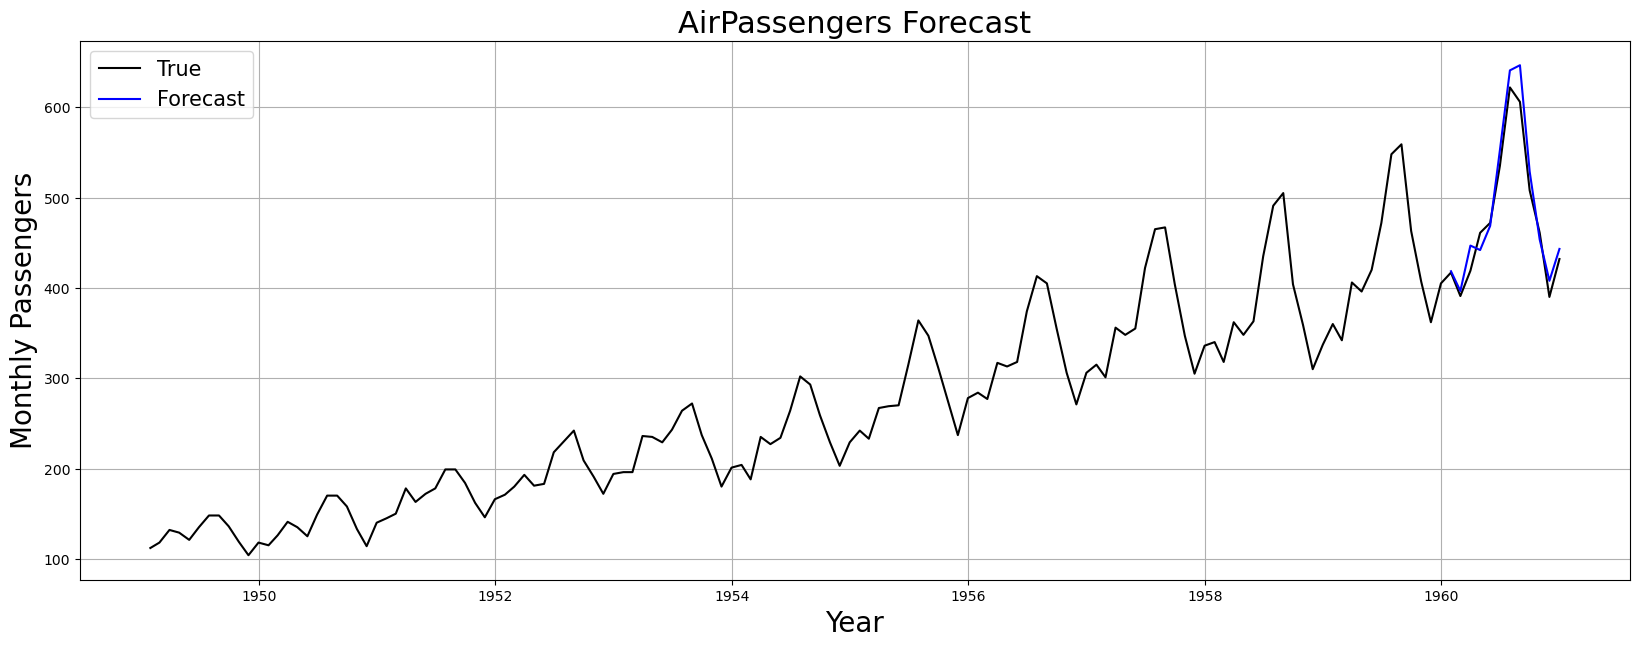

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['iTransformer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()